# Dimensionality reduction

Notebook env to extend the code in `lowDim_embedding.py`

In [5]:
import numpy as np
import numba
import time
import os, sys
import random

In [6]:
sys.path.append('../../')
from src import myTools, plotTools

## System loading

In [7]:
sysdir_path = '../1.dscr_analysis/1.soap_data/soap_rcut4_n8_l4/'
sysname = 'soap_rcut4.5_n_Z1_Z3_Nframe1000every5.npy'

In [8]:
X = np.concatenate(np.load(sysdir_path+sysname))
X.shape

(22800, 5881)

## Dimensionality Reduction

The function `get_embedding` 

In [16]:
from sklearn.decomposition import PCA, KernelPCA
from umap import UMAP

In [17]:
def get_embedding(data, 
                  method, 
                  method_dict,
                  fit=True):
    
    # avaliable general methods
    EMBED_METHODS = dict(
    lpca = PCA,
    kpca = KernelPCA,
    umap = UMAP
    )
    
    if method in EMBED_METHODS.keys():
        embed_model = EMBED_METHODS[method](**method_dict)
    else:
        embed_model = method(**method_dict)
    
    print(f"Data shape: {np.shape(data)}")
    print(f"Method selected: {embed_model}")
    
    if fit:
        return embed_model.fit(data)
    else:
        return embed_model

### Different metrics

Many dim reduction methods can support different metrics and custom metrics definitions.

**Custom defined metrics are not yet implemented in the workflow, just here**

In [18]:
# --- examples:

# SOAP dist with normalized SOAP vectors
def mySOAPdist(A, B, n=1):
    ABker = (np.dot(A, B))**n
    np.seterr(all='raise')
    try:
        (2.0 - 2.0*ABker)**0.5
    except FloatingPointError:
        return 0
    return (2.0 - 2.0*ABker)**0.5

# numba definition (UMAP purpouses)
@numba.njit()
def numbaSOAPdist(A, B, n=1):
    ABker = (np.dot(A, B))**n
    return (2.0 - 2.0*ABker)**0.5

### Subset of data

It may be necessary to ease the computational cost of some method or just for explorative purposes

**Data sampling is not yet implemented in the workflow, just here**

In [19]:
# --- examples:

# - random sampling
def shuffle(X, Y=None, n=None):
    l = np.arange(X.shape[0])
    random.shuffle(l)
    if Y is None:
        return X[l[:n], :]
    elif Y is None and n is None:
        return X[l, :]
    elif n is None:
        return X[l, :], Y[l]
    else:
        return X[l[:n], :], Y[l[:n]]
    
# - FPS
def FPS():
    pass

In [10]:
XX = shuffle(X=X, n=int(len(X)/3.))
XX.shape

(7600, 5881)

## _fit_

In [34]:
# embedding method and dict
method = 'umap'
emb_dict = dict(
    n_neighbors = 7,
    min_dist = 0.001,
    metric = numbaSOAPdist
)

In [35]:
%time embedding = get_embedding(data=X, method=method, method_dict=emb_dict, fit=False)

Data shape: (22800, 5881)
Method selected: UMAP(metric=CPUDispatcher(<function numbaSOAPdist at 0x7f2747019040>), min_dist=0.001, n_neighbors=7)
CPU times: user 46.9 ms, sys: 30.6 ms, total: 77.5 ms
Wall time: 75.7 ms


In [36]:
%time Xemb = embedding.fit_transform(X)

/home/agardin/anaconda3/envs/cambridge_py39/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


CPU times: user 1min 6s, sys: 1.75 s, total: 1min 8s
Wall time: 9.51 s


## Output data

In [37]:
sysInfoName = 'rcut45'
sysSpecInfo = 'SOAPdist'
prod_dir = './'

In [38]:
save_name = sysname.replace('soap_', method+sysSpecInfo+'_')
save_name

'umapSOAPdist_rcut4.5_n_Z1_Z3_Nframe1000every5.npy'

In [39]:
np.save(prod_dir+save_name, Xemb)

In [40]:
# !ls ./dimred_data/

# Plots

In [41]:
removeAXE = True

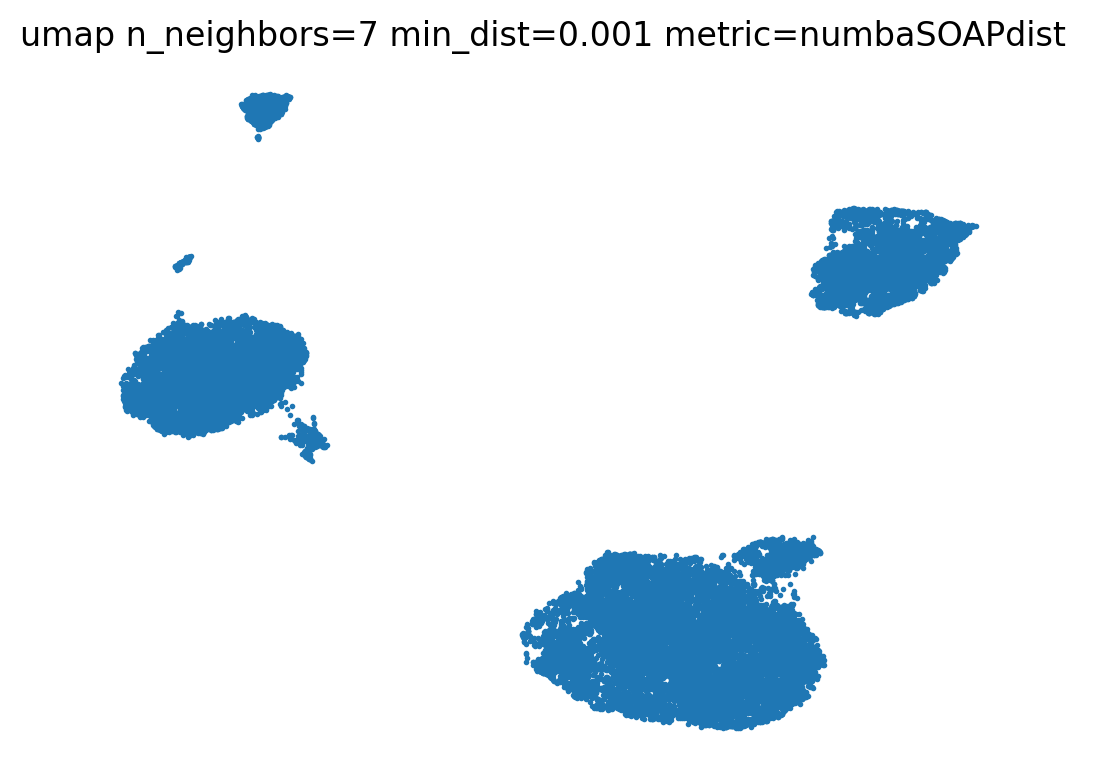

In [42]:
fig, ax = plotTools.get_axes(1)

if Xemb.shape[1] > 2:
    ax.scatter(Xemb[:,0], Xemb[:,1],
                  c=Xemb[:,2], s=10)
elif Xemb.shape[1] == 2:
    ax.scatter(*Xemb.T, s=1)

title_str = ''
for par,val in emb_dict.items():
    if isinstance(val, str):
        title_str += par+'='+val+' '
    elif isinstance(val, int) or isinstance(val, float):
        title_str += par+'='+str(val)+' '
    else:
        title_str += par+'='+val.__name__+' '
    
ax.set_title(f'{method} {title_str}')
if removeAXE:
    plotTools.remove_frame(ax)

fig.tight_layout()
fig.savefig(f"{prod_dir}{method}{Xemb.shape[1]}_reduction_{sysInfoName}{sysSpecInfo}", 
            transparent=True)

In [43]:
if method == 'lpca':
    fig, ax = plotTools.get_axes(1)
    n_ = Xemb.shape[1]
    ax.plot(np.arange(1,n_+1),np.cumsum(embedding.explained_variance_ratio_))
    ax.set_xlabel('number of components')
    ax.set_ylabel('cumulative explained variance')
    fig.tight_layout()
    fig.savefig(f"{prod_dir}{method}{Xemb.shape[1]}_reduction_variance_{sysInfoName}", 
                transparent=True)

### Why kernel PCA does not work

In [12]:
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

In [16]:
# embedding method and dict
method = 'kpca'
emb_dict = dict(
    n_components = 9,
)

Data shape: (7600, 5881)
Method selected: KernelPCA(n_components=9)
KernelPCA(n_components=9) 

Data shape: (7600, 5881)
Method selected: KernelPCA(kernel='poly', n_components=9)
KernelPCA(kernel='poly', n_components=9) 

Data shape: (7600, 5881)
Method selected: KernelPCA(kernel='rbf', n_components=9)
KernelPCA(kernel='rbf', n_components=9) 

Data shape: (7600, 5881)
Method selected: KernelPCA(kernel='sigmoid', n_components=9)
KernelPCA(kernel='sigmoid', n_components=9) 

Data shape: (7600, 5881)
Method selected: KernelPCA(kernel='cosine', n_components=9)
KernelPCA(kernel='cosine', n_components=9) 



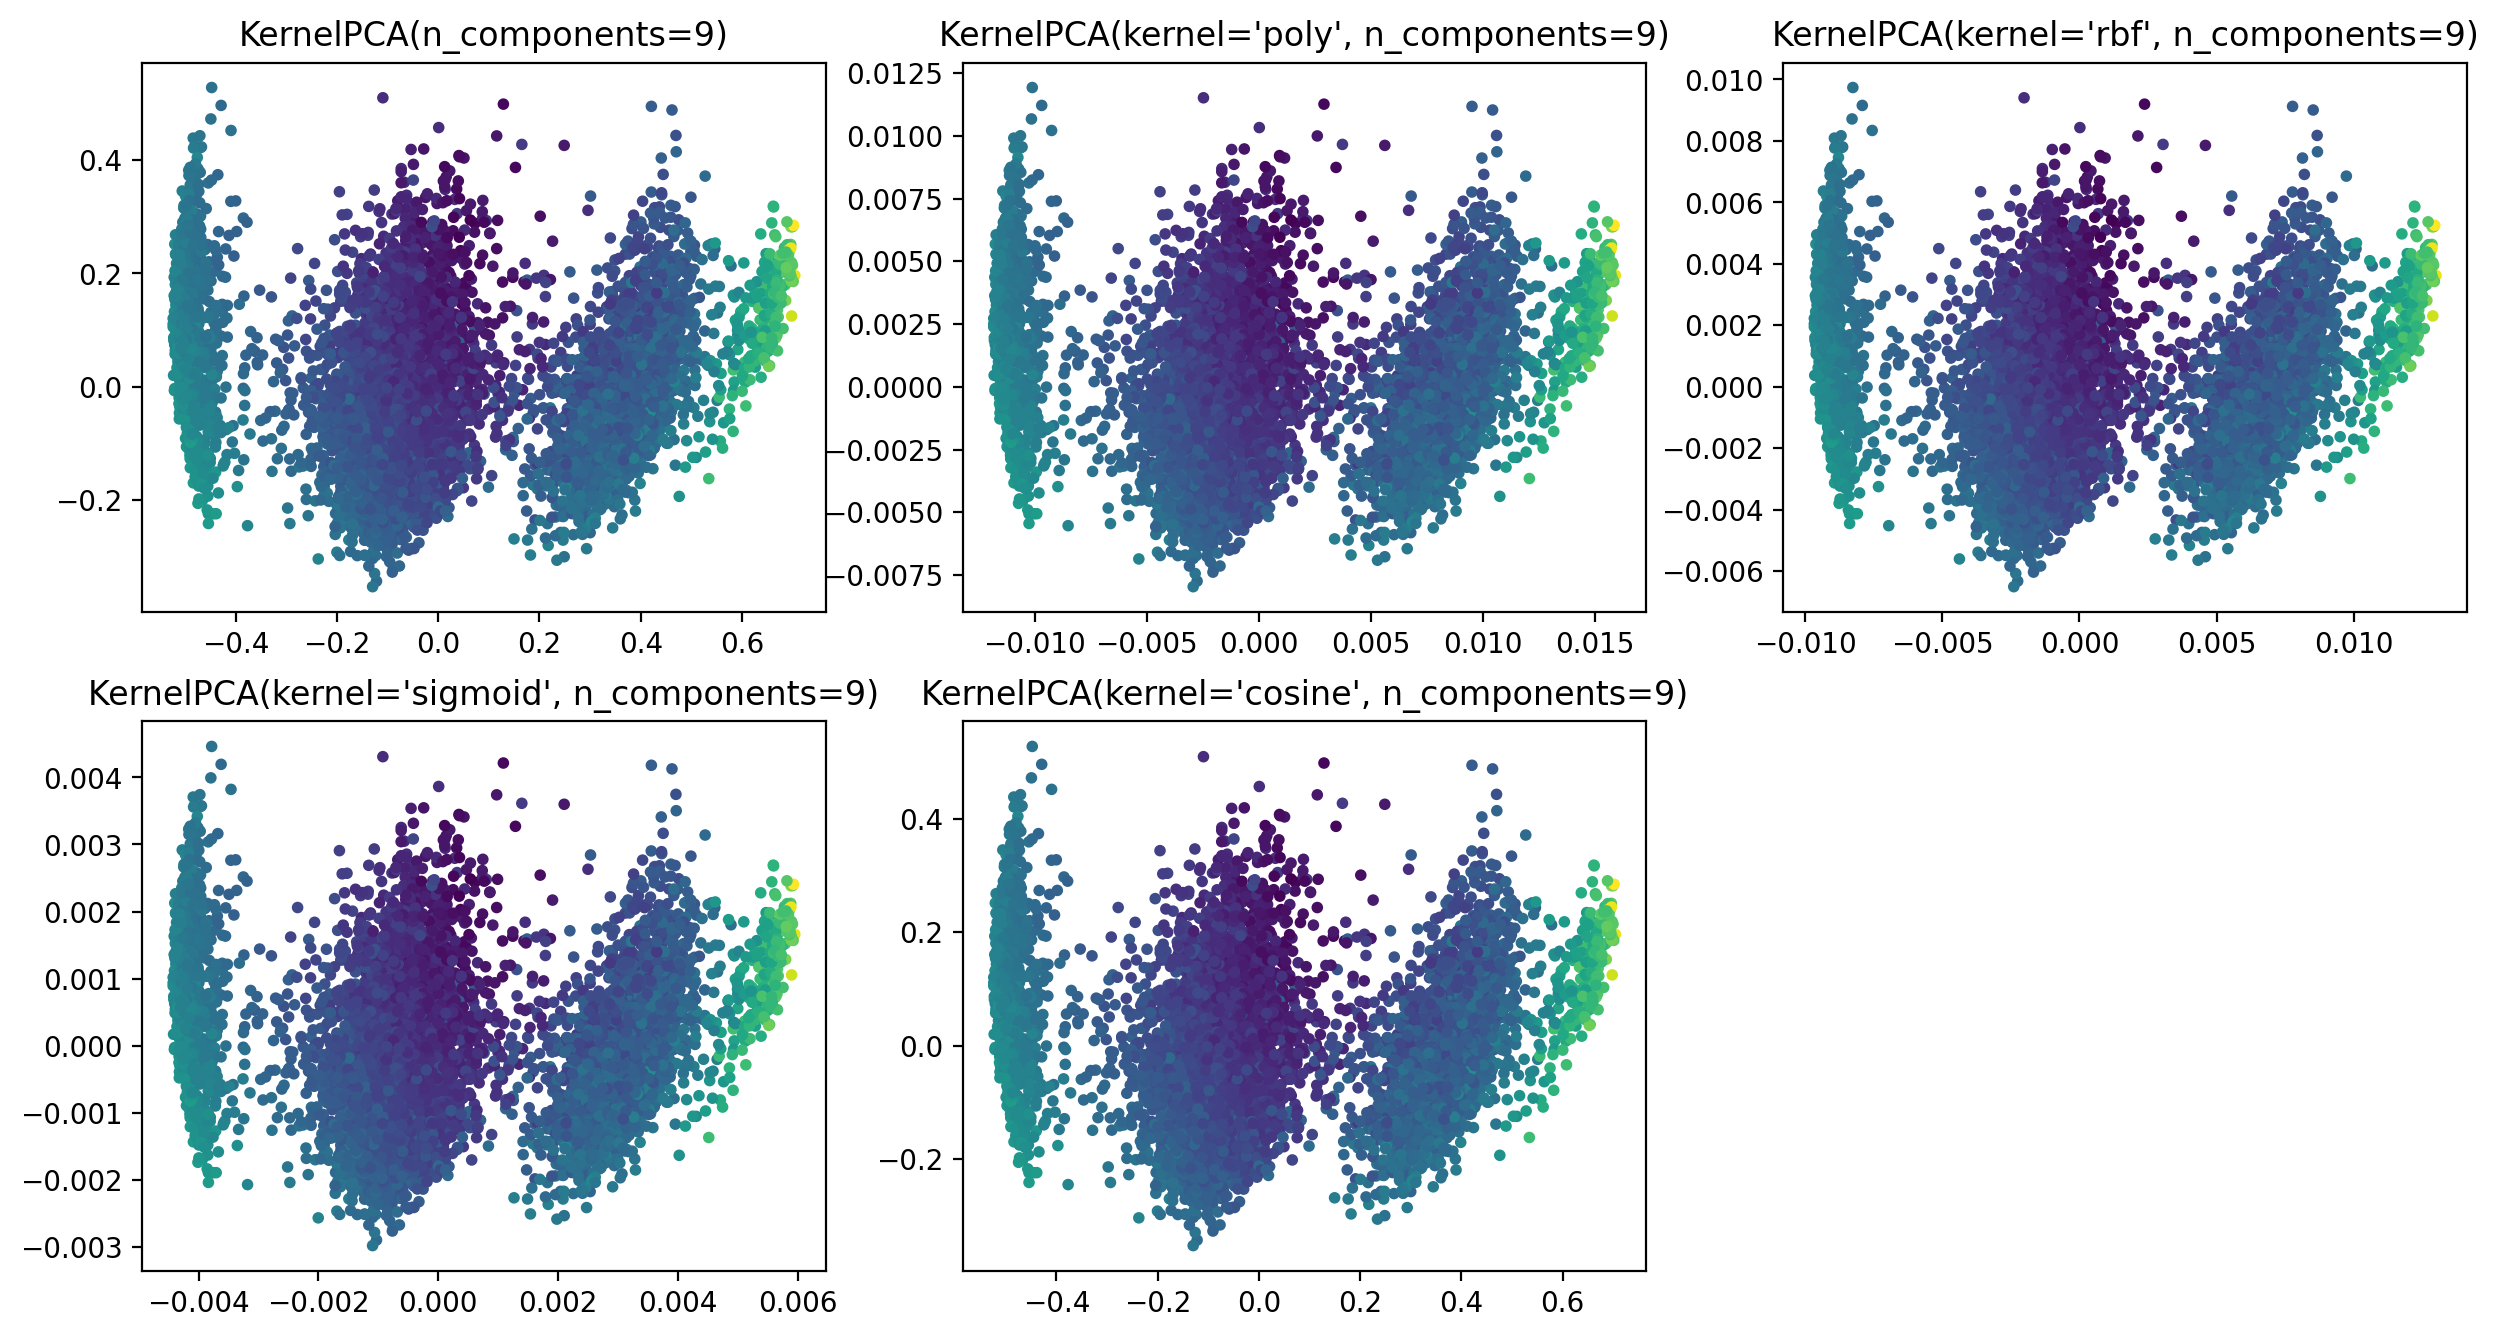

In [17]:
fig, ax = plotTools.get_axes(len(kernel_list), 3)

for i,k in enumerate(kernel_list):
    
    emb_dict.update(kernel=k)
    embedding = get_embedding(data=XX, method=method, method_dict=emb_dict, fit=False)
    print(embedding, '\n')
    
    Xemb = embedding.fit_transform(XX)
    
    ax[i].scatter(Xemb[:,0], Xemb[:,1], c=Xemb[:,2], s=10)
    ax[i].set_title(embedding)
fig.savefig("strange_kpca_reduction")

### Test

In [20]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)

In [21]:
# embedding method and dict
method = 'kpca'
emb_dict = dict(
    n_components = 2,
)

Data shape: (1000, 2)
Method selected: KernelPCA(n_components=2)
KernelPCA(n_components=2) 

Data shape: (1000, 2)
Method selected: KernelPCA(kernel='poly', n_components=2)
KernelPCA(kernel='poly', n_components=2) 

Data shape: (1000, 2)
Method selected: KernelPCA(kernel='rbf', n_components=2)
KernelPCA(kernel='rbf', n_components=2) 

Data shape: (1000, 2)
Method selected: KernelPCA(kernel='sigmoid', n_components=2)
KernelPCA(kernel='sigmoid', n_components=2) 

Data shape: (1000, 2)
Method selected: KernelPCA(kernel='cosine', n_components=2)
KernelPCA(kernel='cosine', n_components=2) 



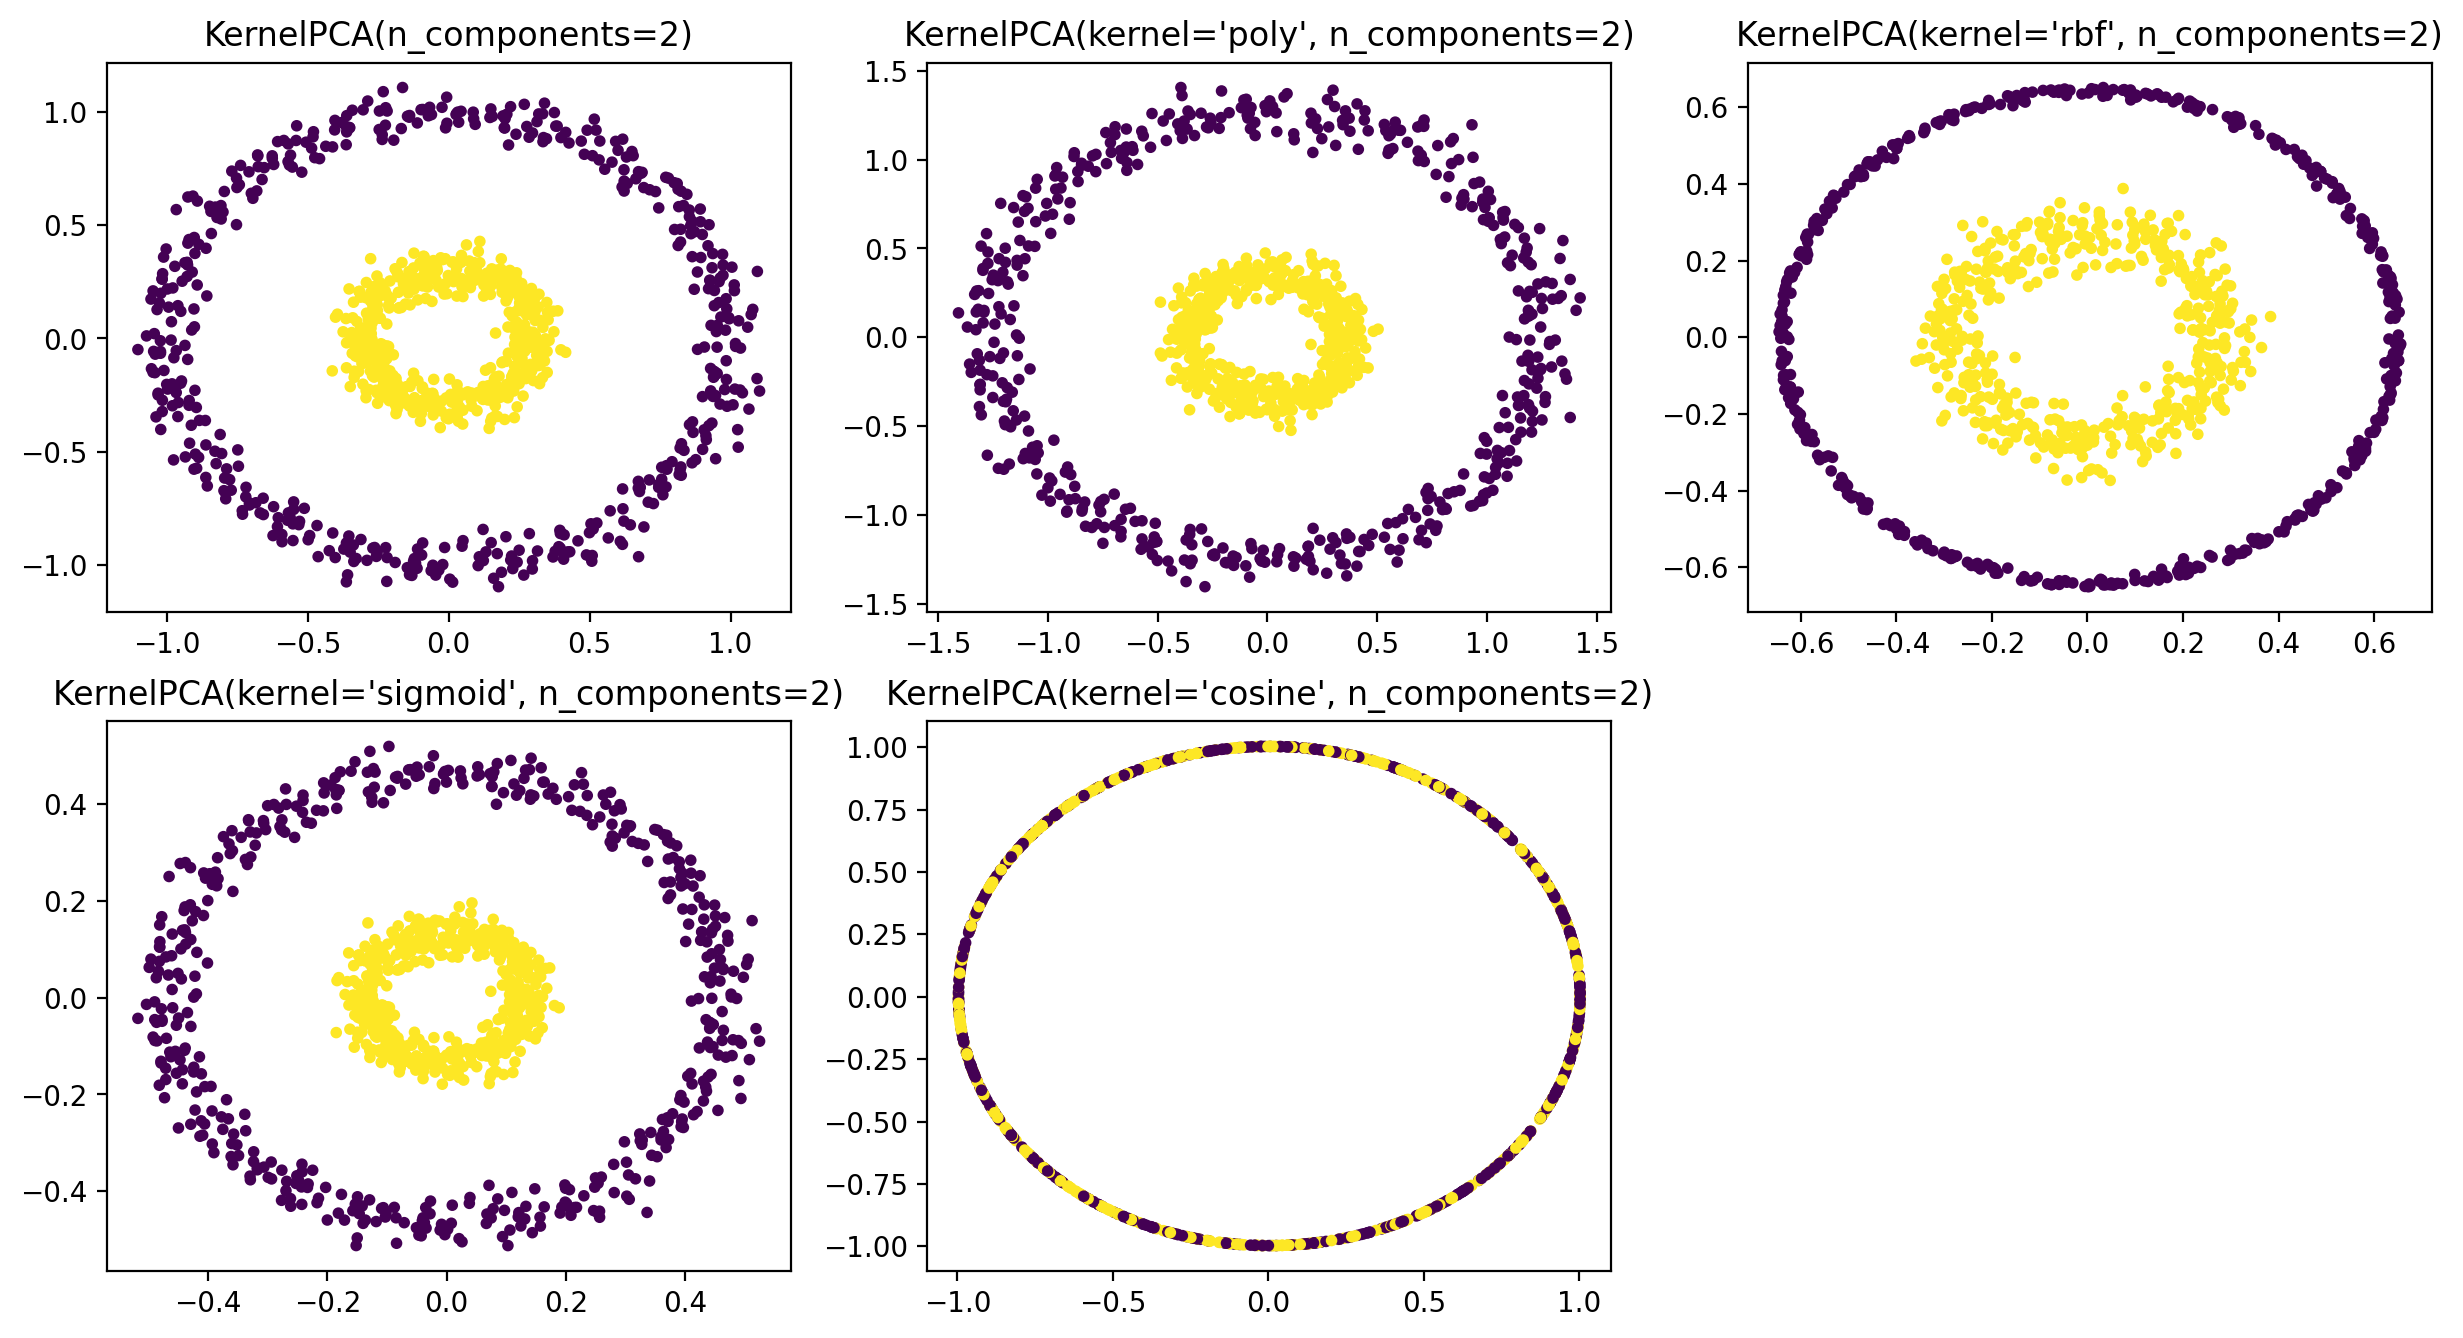

In [24]:
fig, ax = plotTools.get_axes(len(kernel_list), 3)

for i,k in enumerate(kernel_list):
    
    emb_dict.update(kernel=k)
    embedding = get_embedding(data=X, method=method, method_dict=emb_dict, fit=False)
    print(embedding, '\n')
    
    Xemb = embedding.fit_transform(X)
    
    ax[i].scatter(Xemb[:,0], Xemb[:,1], c=y, s=10)
    ax[i].set_title(embedding)
# fig.savefig("strange_kpca_reduction")